# Introduction to LoRA

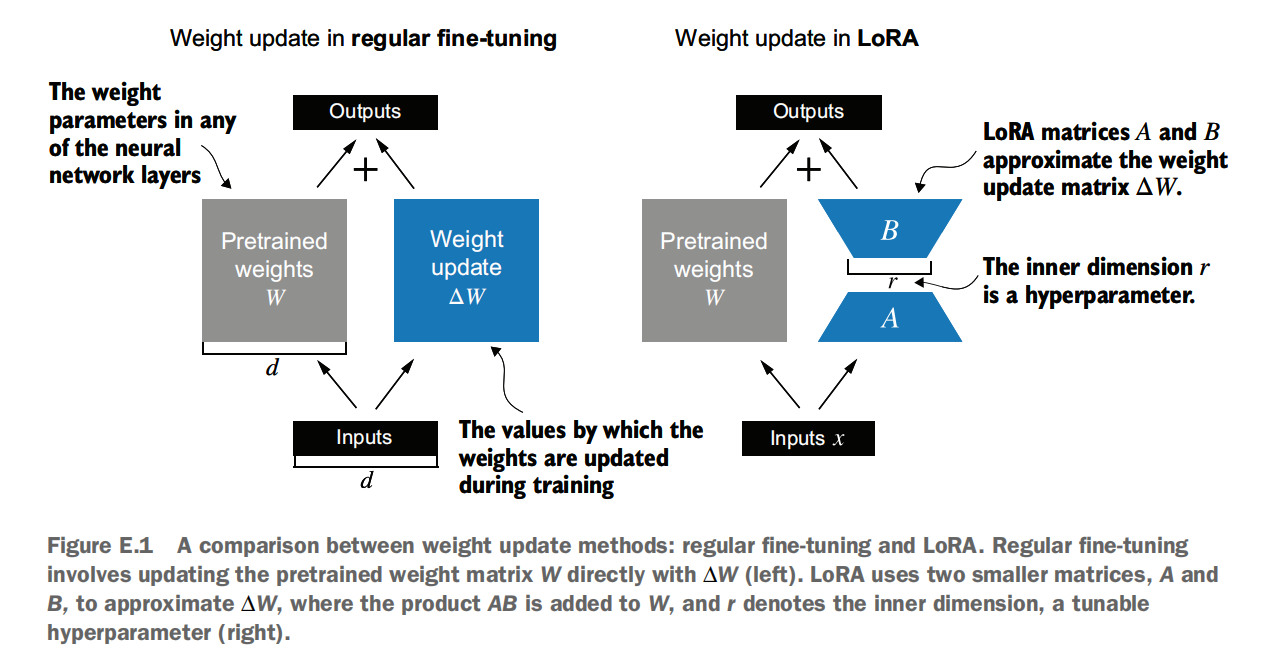

- The distributive law of matrix multiplication,
which allows us to separate the original and updated weights rather than combine
them. For example, in the case of regular fine-tuning with x as the input data, we can
express the computation as


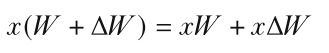

- Similarly, we can write the following for LoRA:

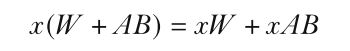

- Besides reducing the number of weights to update during training, the ability to keep
the LoRA weight matrices separate from the original model weights makes LoRA even
more useful in practice. Practically, this allows for the pretrained model weights to
remain unchanged, with the LoRA matrices being applied dynamically after training
when using the model

### Preparing the dataset

In [1]:
from pathlib import Path
import pandas as pd
from utils import (
 download_and_unzip_spam_data,
 create_balanced_dataset,
 random_split
)

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"
download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

df = pd.read_csv(
 data_file_path, sep="\t", header=None, names=["Label", "Text"]
)
balanced_df = create_balanced_dataset(df)
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})
train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)
train_df.to_csv("train.csv", index=None)

validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

c:\Users\AKSHAT SHAW\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


sms_spam_collection\SMSSpamCollection.tsv already exists. Skipping download and extraction.


## Instantiating PyTorch datasets

In [2]:
import torch
from torch.utils.data import Dataset
import tiktoken
from utils import SpamDataset

tokenizer = tiktoken.get_encoding("gpt2")
train_dataset = SpamDataset("train.csv", max_length=None, 
 tokenizer=tokenizer
)
val_dataset = SpamDataset("validation.csv", 
 max_length=train_dataset.max_length, tokenizer=tokenizer
)
test_dataset = SpamDataset(
 "test.csv", max_length=train_dataset.max_length, tokenizer=tokenizer
)

In [3]:
from torch.utils.data import DataLoader
num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_loader = DataLoader(
 dataset=train_dataset,
 batch_size=batch_size,
 shuffle=True,
 num_workers=num_workers,
 drop_last=True,
)

val_loader = DataLoader(
 dataset=val_dataset,
 batch_size=batch_size,
 num_workers=num_workers,
 drop_last=False,
)

test_loader = DataLoader(
 dataset=test_dataset,
 batch_size=batch_size,
 num_workers=num_workers,
 drop_last=False,
)

In [4]:
print("Train loader:")
for input_batch, target_batch in train_loader:
 pass
print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

Train loader:
Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])


## Initializing the model

In [5]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"
BASE_CONFIG = {
 "vocab_size": 50257, 
 "context_length": 1024, 
 "drop_rate": 0.0, 
 "qkv_bias": True 
}
model_configs = {
 "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
 "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
 "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
 "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

GPT_CONFIG_124M = {
 "vocab_size": 50257,
 "context_length": 256, # We shorten the context length from 1,024 to 256 tokens. Original GPT-2 has a context length of 1,024 tokens.
 "emb_dim": 768,
 "n_heads": 12,
 "n_layers": 12, 
 "drop_rate": 0.1, 
 "qkv_bias": False
}

In [6]:
from gpt_download import download_and_load_gpt2, load_weights_into_gpt
from gpt import GPTModel
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")

settings, params = download_and_load_gpt2(                
        model_size=model_size, models_dir="gpt2"
)


File already exists and is up-to-date: gpt2\124M\checkpoint
File already exists and is up-to-date: gpt2\124M\encoder.json
File already exists and is up-to-date: gpt2\124M\hparams.json
File already exists and is up-to-date: gpt2\124M\model.ckpt.index
File already exists and is up-to-date: gpt2\124M\model.ckpt.meta
File already exists and is up-to-date: gpt2\124M\vocab.bpe
File already exists and is up-to-date: gpt2\124M\model.ckpt.data-00000-of-00001


In [7]:
model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [8]:
from gpt import generate_text_simple
from utils import text_to_token_ids, token_ids_to_text
text_1 = "Every effort moves you"
token_ids = generate_text_simple(
 model=model,
 idx=text_to_token_ids(text_1, tokenizer),
 max_new_tokens=15,
 context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work


In [9]:
torch.manual_seed(123)
num_classes = 2

model.out_head = torch.nn.Linear(in_features=768, out_features=num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [10]:
from utils import calc_accuracy_loader
torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(
 train_loader, model, device, num_batches=10
)
val_accuracy = calc_accuracy_loader(
 val_loader, model, device, num_batches=10
)
test_accuracy = calc_accuracy_loader(
 test_loader, model, device, num_batches=10
)

## Parameter-efficient fine-tuning with LoRA

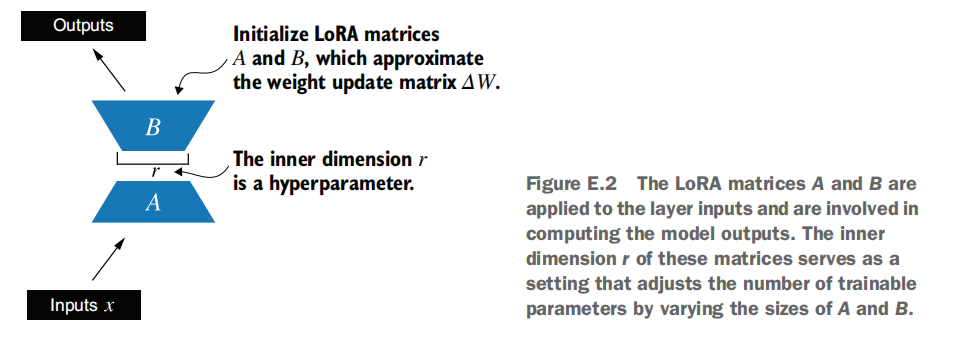

In [11]:
import math

class LoRALayer(torch.nn.Module):
   
   def __init__(self, in_dim, out_dim, rank, alpha):
      super().__init__()
      self.A = torch.nn.Parameter(torch.empty(in_dim, rank))
      torch.nn.init.kaiming_uniform_(self.A, a=math.sqrt(5)) 
      self.B = torch.nn.Parameter(torch.zeros(rank, out_dim))
      self.alpha = alpha
      
   def forward(self, x):
      x = self.alpha * (x @ self.A @ self.B)
      return x

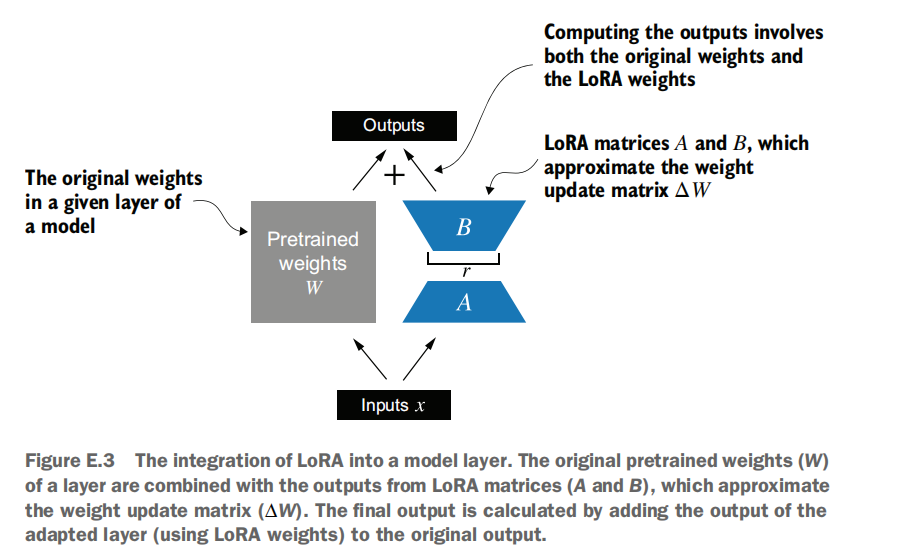

- To integrate the original Linear layer weights, we now create a LinearWithLoRA layer.
This layer utilizes the previously implemented LoRALayer and is designed to replace
existing Linear layers within a neural network, such as the self-attention modules or
feed-forward modules in the GPTModel.

In [12]:
class LinearWithLoRA(torch.nn.Module):
    def __init__(self, linear, rank, alpha):
        super().__init__()
        self.linear = linear
        self.lora = LoRALayer(
            linear.in_features, linear.out_features, rank, alpha
        )
    def forward(self, x):
        return self.linear(x) + self.lora(x)

#### To apply LoRA to the earlier defined GPTModel, we introduce a replace_linear_with_lora function. This function will swap all existing Linear layers in the model with the newly created LinearWithLoRA layers:

In [13]:
def replace_linear_with_lora(model, rank, alpha):
    for name, module in model.named_children():
        if isinstance(module, torch.nn.Linear):  #Replaces the Linear layer with LinearWithLoRA
            setattr(model, name, LinearWithLoRA(module, rank, alpha))
        else:                                       #Recursively applies the same function to child modules
            replace_linear_with_lora(module, rank, alpha)

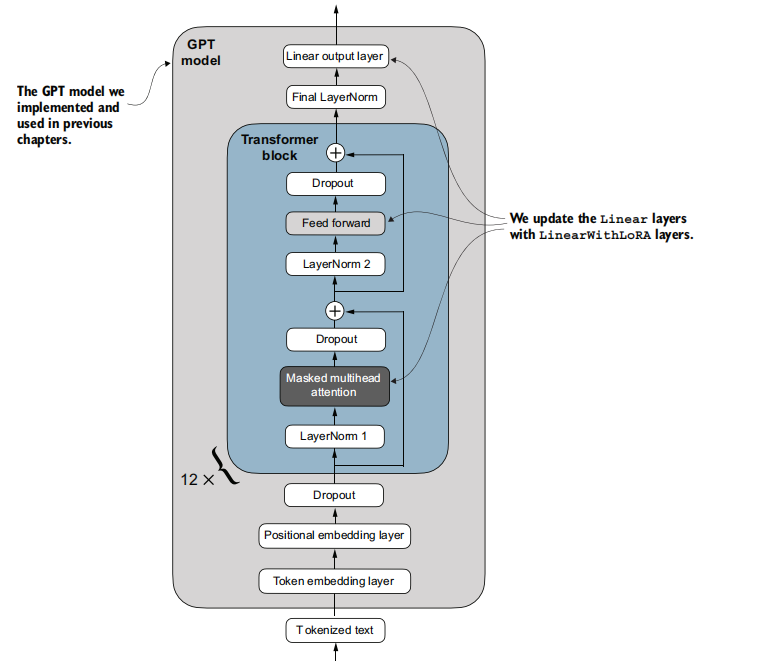

- Before we apply the LinearWithLoRA layer upgrades, we first freeze the original model
parameters:

In [14]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters before: {total_params:,}")

for param in model.parameters():
 param.requires_grad = False  #Freezes all parameters
 
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters after: {total_params:,}")

Total trainable parameters before: 124,441,346
Total trainable parameters after: 0


In [15]:
replace_linear_with_lora(model, rank=16, alpha=16)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total trainable LoRA parameters: {total_params:,}")

Total trainable LoRA parameters: 2,666,528


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (W_key): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (W_value): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (out_proj): LinearWithLoRA(
          (linear): Linear(in_features=768, out_features=768, bias=True)
          (lora): LoRALayer()
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): LinearWithLoRA(
            (linear): Linear(in_features=768, out_featu

In [17]:
torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(
 train_loader, model, device, num_batches=10
)
val_accuracy = calc_accuracy_loader(
 val_loader, model, device, num_batches=10
)
test_accuracy = calc_accuracy_loader(
 test_loader, model, device, num_batches=10
)
print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


In [18]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else: 
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(
            input_batch, target_batch, model, device
            )
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_loss = calc_loss_loader(
        val_loader, model, device, num_batches=eval_iter
        )
    model.train()
    return train_loss, val_loss

In [19]:
from utils import calc_loss_batch

def train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs, eval_freq, eval_iter, project_name="gpt2-peft-lora", run_name=None):
    # Initialize wandb
    wandb.init(project=project_name, name=run_name)
    
    # Log hyperparameters
    wandb.config.update({
        "epochs": num_epochs,
        "eval_frequency": eval_freq,
        "eval_iterations": eval_iter,
        "optimizer": optimizer.__class__.__name__,
        "learning_rate": optimizer.param_groups[0]['lr'],
        "device": device,
        "model_name": model.__class__.__name__
    })
    
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1
    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        batch_count = 0
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            loss.backward()
            optimizer.step()
            
            # Track batch-level metrics
            epoch_loss += loss.item()
            batch_count += 1
            examples_seen += input_batch.shape[0]
            global_step += 1
            
            # Log batch metrics
            wandb.log({
                "batch_loss": loss.item(),
                "examples_seen": examples_seen,
                "global_step": global_step
            }, step=global_step)
            
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                
                # Log evaluation metrics
                wandb.log({
                    "train_loss": train_loss,
                    "val_loss": val_loss,
                    "epoch": epoch + 1
                }, step=global_step)
                
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, "
                      f"Val loss {val_loss:.3f}")
        
        # Calculate and log accuracies at epoch end
        train_accuracy = calc_accuracy_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_accuracy = calc_accuracy_loader(
            val_loader, model, device, num_batches=eval_iter
        )
        
        # Log epoch-level metrics
        wandb.log({
            "epoch": epoch + 1,
            "epoch_avg_loss": epoch_loss / batch_count,
            "train_accuracy": train_accuracy * 100,
            "val_accuracy": val_accuracy * 100,
            "learning_rate": optimizer.param_groups[0]['lr']  # Track if LR changes
        }, step=global_step)
        
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)
    
    # Close wandb run
    wandb.finish()
    return train_losses, val_losses, train_accs, val_accs, examples_seen

In [20]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: akshatshaw47 (akshatshaw47-iit-roorkee). Use `wandb login --relogin` to force relogin


True

In [21]:
import time

start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = \
 train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=5, eval_freq=50, eval_iter=5,
    project_name="gpt2-peft-lora", run_name="lora-m1"
 )
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 3.820, Val loss 3.462
Ep 1 (Step 000050): Train loss 0.396, Val loss 0.364
Ep 1 (Step 000100): Train loss 0.111, Val loss 0.229
Training accuracy: 97.50% | Validation accuracy: 95.00%
Ep 2 (Step 000150): Train loss 0.135, Val loss 0.073
Ep 2 (Step 000200): Train loss 0.008, Val loss 0.052
Ep 2 (Step 000250): Train loss 0.021, Val loss 0.178
Training accuracy: 97.50% | Validation accuracy: 97.50%
Ep 3 (Step 000300): Train loss 0.089, Val loss 0.075
Ep 3 (Step 000350): Train loss 0.113, Val loss 0.263
Training accuracy: 100.00% | Validation accuracy: 100.00%
Ep 4 (Step 000400): Train loss 0.012, Val loss 0.056
Ep 4 (Step 000450): Train loss 0.018, Val loss 0.127
Ep 4 (Step 000500): Train loss 0.009, Val loss 0.066
Training accuracy: 100.00% | Validation accuracy: 97.50%
Ep 5 (Step 000550): Train loss 0.007, Val loss 0.035
Ep 5 (Step 000600): Train loss 0.030, Val loss 0.039
Training accuracy: 100.00% | Validation accuracy: 95.00%


batch_loss,▇▇█▅▄▂▂▂▁▂▂▁▁▇▁▅▁▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁█▁▁
epoch,▁▁▁▁▃▃▃▃▅▅▅▆▆▆▆███
epoch_avg_loss,█▃▂▁▁
examples_seen,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇████
global_step,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▅▅▆▆▆▆▆▇▇▇█████
learning_rate,▁▁▁▁▁
train_accuracy,▁▁███
train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅█▅▁
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁
batch_loss,0.01098


Training completed in 3.82 minutes.


In [22]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 99.62%
Validation accuracy: 96.64%
Test accuracy: 96.67%


# End of Notebook